### 2020_05_16 データ分析
データ整形がだいたい終わったので実際に細かくデータを見ていく。これまで材料をgに直すデータ整形を主にやっていたので、材料のデータを主にみていく。

In [1]:
import team1_module as t1 #モジュールのimport
import pandas as pd

あんまりデータ数が多くても処理が重くなるだけなので、2000年を対象にする


In [ ]:
df_ingredient = t1.read_ingredient(2000) #材料データの読み込み
df_recipe = t1.read_recipe(2000) #レシピデータの読み込み、後で使う

df_ingredient_c = t1.clean_ingredient(df_ingredient) #データ整形の関数

In [181]:
df_ingredient = t1.read_ingredient(2000) #材料データの読み込み

とりあえず、生データでどういう食材が多いか調べる。

In [182]:
res = df_ingredient["ingredient"].value_counts()
res[:20]

塩          1284
砂糖         1026
卵           844
バター         634
醤油          556
牛乳          516
酒           503
水           454
しょうゆ        449
にんにく        407
小麦粉         368
こしょう        348
サラダ油        341
玉ねぎ         339
薄力粉         327
生クリーム       312
ごま油         310
みりん         297
オリーブオイル     264
マヨネーズ       262
Name: ingredient, dtype: int64

やはり砂糖、塩などよく使われる食材が表示される。
もともと、料理の味を食材によって定量的に評価したかったので、食材をgに整形していく。データ整形のやり方としては、g表記のものはgを取り除くだけだが、大さじ/小さじ+数字と記載されてるものについては、それぞれ15g,5gとして計算し、データが欠落しているもの、また適量と書いてあるものについては0.5とした。なお、この過程で、"☆"などの記号や、全角から半角に変換している。

In [184]:
df_ingredient_c = t1.clean_ingredient(df_ingredient) #データ整形の関数に通す
res = df_ingredient_c["ingredient"].value_counts()
res[:20]

塩            797
砂糖           452
バター          307
こしょう         279
薄力粉          275
コショウ         144
ベーキングパウダー    121
グラニュー糖       113
小麦粉          112
無塩バター        110
醤油           105
胡椒            95
ごま油           93
しょうゆ          89
クリームチーズ       74
レモン汁          61
酒             60
バニラエッセンス      59
塩こしょう         51
片栗粉           51
Name: ingredient, dtype: int64

塩、砂糖は変わらなかったが、卵、ニンニクなどが消えて粉ものが上位に来た。データ整形前後のデータの大きさの差は以下の通り。

In [185]:
print(df_ingredient.size)
print(df_ingredient_c.size)

101892
23211


### 仮説1：ほとんどの料理で使われる調味料なら料理の味を定量化できる
2000年に使われている食材の総数は

In [188]:
df_ingredient["ingredient"].value_counts().size

5754

食材数で5754こ存在する。たとえ単純によく使われる上位10の食材でもかなり疎な表現になってしまう。そこで、ひとまず調味料だけにしぼって考える。幸い、調味料は大さじ、小さじによる表記が多いため比較的gに変換しやすい。実際、塩のデータ数をデータ整形残後で比較してみると

In [186]:
print(df_ingredient[df_ingredient["ingredient"]=="塩"].size)
print(df_ingredient_c[df_ingredient_c["ingredient"]=="塩"].size)

3852
2391


データ総数が1/5になったのに対し、2/3程度しか減っていない。これより比較的十分なデータ数が集まると思い、各料理ごとにgを単位とする調味料ベクトルを作成する。  
今回は上位にある砂糖、塩、塩こしょう、バター、醤油を調味料ベクトルとする。そのまえに、グラニュー糖と砂糖など表記の揺れがあるので、それをなくす。結果論だが、1998-2014年のデータをまとめると塩こしょうがたくさん出てくるため塩こしょうにしたが、2000年のみで見るとこしょう単体のほうが多いと感じたので

In [192]:
vec_list = ["砂糖","塩","バター","塩こしょう","醤油"] #今回参考にする調味料
df_ingredient_c_sum = t1.sum_seasoning(df_ingredient_c) #調味料をまとめる
df_ingredient_c_sum_cut = df_ingredient_c_sum[df_ingredient_c_sum["ingredient"].isin(vec_list)]

def mk_vector(df): #調味料ベクトルを作成する。
    
    vec = pd.DataFrame(columns = ["recipeID","sugar","salt","butter","pepper","soysource"],index=[])
    vec_dic = {"砂糖":"sugar","塩":"salt","バター":"butter","塩こしょう":"pepper","醤油":"soysource"}
    vec["recipeID"] = df["recipeID"]
    for row in df.itertuples():
        vec.loc[vec["recipeID"]==row.recipeID,vec_dic[row.ingredient]] = row.size
        
    vec = vec.fillna(0)
    return vec

vec = mk_vector(df_ingredient_c_sum_cut)
vec[:20]

,recipeID,sugar,salt,butter,pepper,soysource
5,0025761763a0e889198f8862ac891928963af837,0.0,0.0,0.0,0.5,0.0
23,0032dbe8954375e03bf030fbdac56b71036cf8db,0.0,0.5,0.0,0.5,0.0
24,0032dbe8954375e03bf030fbdac56b71036cf8db,0.0,0.5,0.0,0.5,0.0
37,00622337a9852af1fc0b8d6865b142c8946b5649,0.0,5.0,0.0,0.0,0.0
44,00a1613b57c9b3f4b4866ef42ec42a38dacbb2b3,0.0,0.0,125.0,0.0,0.0
56,00bdd3c327ea313f330360f21f925d87fd5d4996,0.0,0.0,0.0,0.5,0.5
59,00bdd3c327ea313f330360f21f925d87fd5d4996,0.0,0.0,0.0,0.5,0.5
63,00c3733f8a59b4dfa7c4f63ded8c0a5ad2193111,0.0,0.5,30.0,0.0,0.0
66,00c3733f8a59b4dfa7c4f63ded8c0a5ad2193111,0.0,0.5,30.0,0.0,0.0
97,010cf068ef711088720b000ff9849b9c6a97c8c4,90.0,0.0,0.0,0.0,0.0


各項目ごとでプロットしてみる。


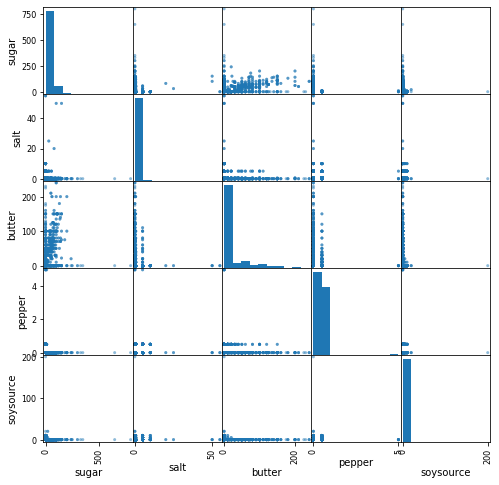

In [193]:
import matplotlib.pyplot as plt
%matplotlib inline

from pandas import plotting 
plotting.scatter_matrix(vec.iloc[:, 1:], figsize=(8, 8), alpha=0.5)
plt.show()

ほとんど値が散らばらなかった。バター、砂糖は値がしっかりと分散していて、砂糖-バター図は散布図になっているが、ほかはほとんどの値がつぶれてしまっている。特にsoysource、saltはほとんど0である。

### 仮設2：料理あたりのつくれぽの数を人気として、追加データとする
そもそも、もともとの目標としてはおいしいおつまみを求めることであった。しかし、食材のみによるおいしさの分析が食材数の数もあって困難なので、疑似的なおいしさの指標としてつくれぽの数を付け加えてみる。

In [195]:
df_report = t1.read_report(2000)
repo_num = df_report["recipeID"].value_counts()
repo_num[:20]

53fac1059a0ed4d4e1e0ddabbb77d96e5094f1e8    1456
0caad21c9630c106dd1f49f6fe8c7883b1677bb5    1151
d560ab553a60f2a77ac001676fcad37fc8706140     344
0918c05d92aec019e2aca2a9291ec64a8a2aedbf     188
69ad06a44ae57566e05bb5338f04f9b2e9b10c78     126
ae462e95eadf34b7b03939fa0d16928f7e658334     106
b45efd13f5a61c3beaf76f8424f6fd818baf3a7a      48
ef0737f6d24edf5061e6e4c1b19158bd7c70ed31      45
ef9607dd07637beaec58a4cd06276828d1014312      44
2d91cf3d58d18bd178b0abaa140422b21a0c073b      39
2c1396ef59c22bbb1b06895dbc90f86d4f4b2c14      38
efced25dc7db9cc21896ffd77247f2ccf934ec90      28
9a2f48ea5c5f19f5795aabee8be9fc04a9d5471d      19
a640cfecc419ffe2e99da68cca945a01b5acd2b5      19
019e8d496aadb8270f64ce0b6444f7951261d81a      18
9220024e56bdfaaa454357adefd309c5eafd0944      16
0fecd80b4fcc40ccc65003cb48698a0782ca834c      14
4a1dc6a89893a9f4951be68a1a7d84d457c8a434      13
cfb503debfbca44994377b5d2b286d82b4ac251b      12
1231f05067f313f3f0dc172b293c1c8c1a680ef9      12
Name: recipeID, dtyp

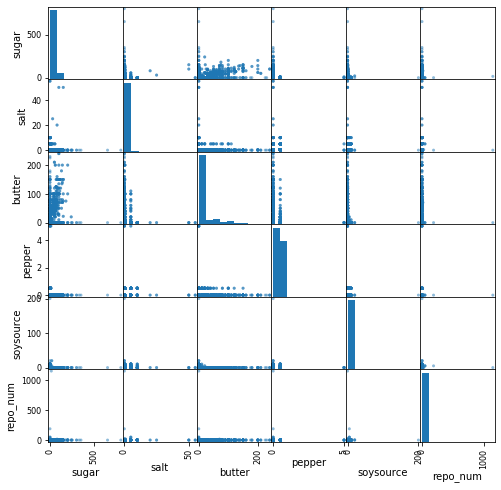

In [196]:
df_repo_num = repo_num.reset_index()
df_repo_num = df_repo_num.rename(columns = {"index":"recipeID","recipeID":"repo_num"}) #集計結果をDataFrameに直す
repo_vec = vec.copy()
repo_vec["repo_num"] = 0

for row in df_repo_num.itertuples():
    repo_vec.loc[repo_vec["recipeID"]==row.recipeID,"repo_num"] = row.repo_num
    
plotting.scatter_matrix(repo_vec.iloc[:, 1:], figsize=(8, 8), alpha=0.5)
plt.show()

結果はあまり変わらなかった。プロットする前につくれぽのデータを見てもらえばわかるのだが、つくれぽ数上位1,2が1000越えに対し、3位から急に300くらいになり、7位くらいで50くらいになっていることから、つくれぽの数を単純においしさの指標とするのはかなり無理がある結果となった。

### 本題：おつまみについて
今まではあくまでデータ整形がすべての料理に関して適用できたため、ひとまず全体を見ていたが、我々のもともとのトピックはおつまみであるので、おつまみに絞って上で行ったデータ分析を行ってみる。

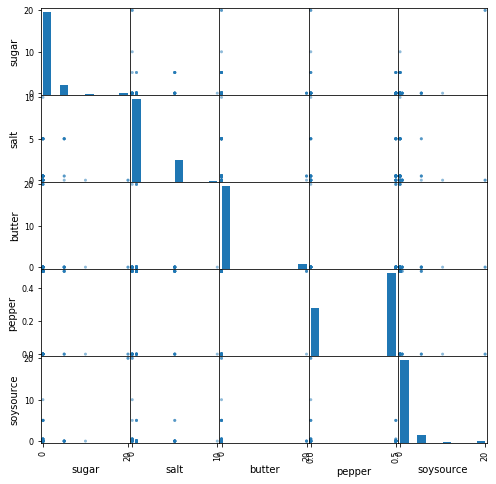

In [197]:
def extract_something(df,sth): #料理名と詳細からあるワードを含むものを返す
    x=df[df["recipe_name"].str.contains(sth,na=False)]
    y=df[df["details"].str.contains(sth,na=False)]
    z=x.append(y)
    a=set(z["recipeID"])
    return df[df["recipeID"].isin(a)]

otsumami_recipe = extract_something(df_recipe,"おつまみ")
otsumami_vec = vec[vec["recipeID"].isin(otsumami_recipe["recipeID"])]
plotting.scatter_matrix(otsumami_vec.iloc[:, 1:], figsize=(8, 8), alpha=0.5)
plt.show()

もともとのデータ数が少ないのもあるが、バターがほとんどなくなりかわりに醤油、塩などの項目が増えた。だが、相変わらずかなり疎な散布図となっている。データ数が少ないのである程度の年数をおつまみに絞ってまとめて処理してみる。

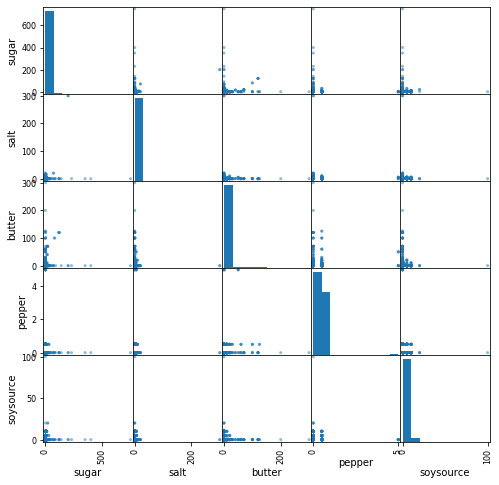

In [198]:
dflist_ingredient = []
dflist_recipe = []

years = [1998,1999,2000,2001,2002,2003,2004,2005,2006,2007]

for year in years:
    df = t1.read_ingredient(year)
    dflist_ingredient.append(df)
    df = t1.read_recipe(year)
    dflist_recipe.append(df)
    
df_ingredient = pd.concat(dflist_ingredient)
df_recipe = pd.concat(dflist_recipe)

otsumami = extract_something(df_recipe,"おつまみ") #おつまみを含むレシピ名を抽出
otsumami_ingredient = df_ingredient[df_ingredient["recipeID"].isin(otsumami["recipeID"])] #材料からおつまみの料理のやつを抽出
otsumami_ingredient_c = t1.clean_ingredient(otsumami_ingredient) #データ整形
otsumami_ingredient_c_sum = t1.sum_seasoning(otsumami_ingredient_c)
otsumami_ingredient_c_sum_cut = otsumami_ingredient_c_sum[otsumami_ingredient_c_sum["ingredient"].isin(vec_list)]
otsumami_vec_long = mk_vector(otsumami_ingredient_c_sum_cut)
plotting.scatter_matrix(otsumami_vec_long.iloc[:, 1:], figsize=(8, 8), alpha=0.5)
plt.show()

データ数が増えたことによって、砂糖、バターの値がばらついた。しかし、砂糖-バターの散布図は相変わらず軸の近くである。  
### 結果：塩、醤油などの調味料では料理ごとにほとんどばらつきがない。
おつまみに絞る前から結果は出ていたが、やはり塩、こしょうなどの調味料では各料理にばらつきは出にくい。かといって、たくさんの食材を使うと疎な行列となってしまう。
### 次回やること
おつまいに絞った食材のランキングを見てみる。

In [200]:
otsumami_ingredient["ingredient"].value_counts()[:20]

塩          956
醤油         733
マヨネーズ      570
ごま油        570
酒          517
砂糖         467
しょうゆ       457
にんにく       411
サラダ油       378
片栗粉        334
バター        314
みりん        312
きゅうり       308
卵          291
水          288
オリーブオイル    283
小麦粉        265
揚げ油        241
じゃがいも      235
大葉         233
Name: ingredient, dtype: int64

料理全体と違って、塩、醤油、マヨネーズ、ごま油などラインナップが変わっている。また、にんにく、きゅうりなど具体的な食材も出てきているためおつまみに絞る場合、おつまみ専用の調味料リストを考えたほうがよさそう。また、きゅうり、にんにくのデータを見ると

In [203]:
otsumami_ingredient[otsumami_ingredient["ingredient"] == "きゅうり"][:20]

,recipeID,ingredient,size
732,491c5a2580941b1c4133fc398028caa4fd4df8eb,きゅうり,２本
10500,518937857787a18ad41d9b12f5a53b813f3b373f,きゅうり,１本
11955,5ce777196e73d6e762e627a8fb5bfc1fcc53411e,きゅうり,２本
13386,661abd2abb9bd0b93c460cb7642fbd03b9693f77,きゅうり,１～２本
22874,aeb05c263a36da94ed2f419c678d0032e3a3ebe3,きゅうり,1/2～１本
28306,d79037e0c0c5cf365b40666ec26ad51a66cb0964,きゅうり,２・３本
29544,e06e72b4d9c8ce86377e44587e42d86b2b27c072,きゅうり,２本
32954,f87cf3067b608b3048fcdb2a84bbbfe1e85d94a3,きゅうり,2本
33328,fb2c8e83cc55a9f9f8d6c341a8fa2755d158e5d1,きゅうり,１本
17701,38af96d6c34fcaa7f013cdd53e7e39a8fe5d6b1d,きゅうり,1/2本


In [204]:
otsumami_ingredient[otsumami_ingredient["ingredient"] == "にんにく"][:20]

,recipeID,ingredient,size
1075,6e4eae162fe0353089b58bf079c5d476c9db160e,にんにく,1粒
891,077f34aec629ea6de46d2a007140319f0cf47444,にんにく,1/3個
4439,216000a1860f36f7be74889ce7ddecb8c09e1de0,にんにく,２かけくらい
5614,2b2acd510c4e920304bc0c951a127e309f110e5a,にんにく,適量(お好みで)
8430,42163a99d7360f7eac7e17fec63540ef92db3ee6,にんにく,中国産なら２かけ
10165,4f75baf77bce50d61c18b8de6ccd5c010a995f1b,にんにく,少々
13395,661abd2abb9bd0b93c460cb7642fbd03b9693f77,にんにく,半かけ位
22604,acc4a11c7b06c79f23e62e2234344f91dbb9001c,にんにく,好みの量
24272,b971c07544c3daa4e0486794869402aa49ab5c31,にんにく,1片
25072,bfb94827e0a697e0e9132406ddc6fa7fd326a419,にんにく,1/2ｶｹすり下ろし


きゅうりはほとんどが数字+本という表現になっており、にんにくもきゅうりほどではないが数字＋かけ/片という表現になっているので、これらを定量化して分析する。